# Data prep future
This is a notebook to read in raw datasets and transform them into datasets for a neural network. <br>
Steps done:<br>

    - Interpolating ECEarth to WRF 4km grid
    - Coarsening ECEarth to an ... km grid from the 4 km grid
    - Coarsening NCEP to an 18km grid from the 3km grid
    - Writing data to .tfrecord files

In [1]:
# data
import netCDF4 as nc
import numpy as np

import pandas as pd
import scipy
from scipy.interpolate import RegularGridInterpolator

# models 
import tensorflow as tf
print(tf.__version__)
#tf.compat.v1.disable_eager_execution()
#tf.disable_eager_execution()
tf.compat.v1.enable_eager_execution()

# must be True
print(tf.executing_eagerly())

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

import os

import helper_functions as hf
from skimage.metrics import structural_similarity as ssim

import importlib as imp

2.8.0
True


Module helper_functions contains self-made and are kept there to make this document more readable. To reload the module after changes to any of its functions use the imp.reload(hf) function below.

In [2]:
imp.reload(hf)

<module 'helper_functions' from 'E:\\Universiteit\\Jaar_6\\Master_Thesis_Part_2\\Sebastian_modified_software\\helper_functions.py'>

### Reading in the datasets

#### WRF Future test data 2041

(2920, 17, 11) (2920, 17, 11) (2920, 17, 11)


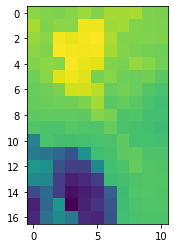

In [3]:
ds_WRF2041 = nc.Dataset('F:/Master_Thesis/Data/WRF data/wrf_2041_4km_3h.nc')

#variables
T_WRF_4km_2041 = np.array(ds_WRF2041['T2'])
U_WRF_4km_2041 = np.array(ds_WRF2041['U10'])
V_WRF_4km_2041 = np.array(ds_WRF2041['V10'])

print(T_WRF_4km_2041.shape, U_WRF_4km_2041.shape, V_WRF_4km_2041.shape)
plt.imshow(T_WRF_4km_2041[0,:,:])


In [4]:
c5 = nc.Dataset('F:/Master_Thesis/Data/WRF data/More_time_runs/LAT_Garda_d02_part1.nc')
c6 = nc.Dataset('F:/Master_Thesis/Data/WRF data/More_time_runs/LON_Garda_d02_part1.nc')

c7 = nc.Dataset('F:/Master_Thesis/Data/WRF data/More_time_runs/LAT_Garda_d02_part2.nc')
c8 = nc.Dataset('F:/Master_Thesis/Data/WRF data/More_time_runs/LON_Garda_d02_part2.nc')

lat_WRF_3km_part1 = np.array(c5['XLAT'][0])[:,0:96]
lon_WRF_3km_part1 = np.array(c6['XLONG'][0])[:,0:96]

lat_WRF_3km_part2 = np.array(c7['XLAT'][0])
lon_WRF_3km_part2 = np.array(c8['XLONG'][0])

print(lon_WRF_3km_part1.shape)

# data

ds1 = nc.Dataset('F:/Master_Thesis/Data/WRF data/More_time_runs/T2_Garda_d02_part1.nc')
ds2 = nc.Dataset('F:/Master_Thesis/Data/WRF data/More_time_runs/T2_Garda_d02_part2.nc')
ds3 = nc.Dataset('F:/Master_Thesis/Data/WRF data/More_time_runs/U10_Garda_d02_part1.nc')
ds4 = nc.Dataset('F:/Master_Thesis/Data/WRF data/More_time_runs/U10_Garda_d02_part2.nc')
ds5 = nc.Dataset('F:/Master_Thesis/Data/WRF data/More_time_runs/V10_Garda_d02_part1.nc')
ds6 = nc.Dataset('F:/Master_Thesis/Data/WRF data/More_time_runs/V10_Garda_d02_part2.nc')

# u-component of wind
U_WRF_3km_part1 = np.array(ds3['U10'])[:,:,0:96]
U_WRF_3km_part2 = np.array(ds4['U10'])

# v-component of wind
V_WRF_3km_part1 = np.array(ds5['V10'])[:,:,0:96]
V_WRF_3km_part2 = np.array(ds6['V10'])

U_WRF_3km_part1.shape, U_WRF_3km_part2.shape

#temp
T_WRF_3km_part1 = np.array(ds1['T2'])[:,:,0:96]
T_WRF_3km_part2 = np.array(ds2['T2'])

T_WRF_3km_part1.shape, T_WRF_3km_part2.shape

#Test 2021
#3km
T_WRF_3km_2021 = T_WRF_3km_part2[10144:13064,:,:] #other indices because part 2 of d02 is not the same as d01
U_WRF_3km_2021 = U_WRF_3km_part2[10144:13064,:,:] #other indices because part 2 of d02 is not the same as d01
V_WRF_3km_2021 = V_WRF_3km_part2[10144:13064,:,:]

T_WRF_3km_2021 = T_WRF_3km_2021[:, 0:30, 0:30]
U_WRF_3km_2021 = T_WRF_3km_2021[:, 0:30, 0:30]
V_WRF_3km_2021 = T_WRF_3km_2021[:, 0:30, 0:30]

print(U_WRF_3km_2021.shape)
print(T_WRF_3km_2021.shape)


#9km temp
ds7 = nc.Dataset('F:/Master_Thesis/Data/WRF data/More_time_runs/T2_Garda_d01_part2.nc')

T_WRF_9km_part2 = np.array(ds7['T2'])
T_WRF_9km_2021 = T_WRF_9km_part2[10136:13056,:,:] #8 indices to much, because 5 years should have 14608 (1 year = 2920 indices)
print(T_WRF_9km_2021.shape)

(31, 31)
(2920, 30, 30)
(2920, 30, 30)
(2920, 31, 26)


In [6]:
#interpolation
lon_WRF_4km_2041 = np.array(ds_WRF2041['XLONG'])
lat_WRF_4km_2041 = np.array(ds_WRF2041['XLAT'])
                            
print(lat_WRF_4km_2041)

[[45.419144 45.419605 45.42004  45.42046  45.420853 45.421223 45.421574
  45.421894 45.422203 45.422478 45.422737]
 [45.455135 45.4556   45.45604  45.456467 45.456852 45.457226 45.457573
  45.457897 45.458195 45.45847  45.45873 ]
 [45.491135 45.4916   45.492035 45.492455 45.492847 45.493217 45.493572
  45.493893 45.494194 45.494476 45.494736]
 [45.527126 45.52759  45.52803  45.528454 45.528843 45.529213 45.529564
  45.529896 45.53019  45.53047  45.53073 ]
 [45.56312  45.56359  45.56403  45.564445 45.564835 45.56522  45.565563
  45.565887 45.566193 45.566475 45.566723]
 [45.599113 45.599583 45.60003  45.60045  45.60084  45.60121  45.60156
  45.601883 45.60219  45.60247  45.602726]
 [45.635113 45.635582 45.636013 45.636444 45.636837 45.637207 45.637554
  45.63788  45.638184 45.638462 45.638725]
 [45.671112 45.671574 45.672016 45.672436 45.672832 45.673206 45.67356
  45.67388  45.674187 45.674465 45.674725]
 [45.707108 45.70757  45.708015 45.70844  45.708828 45.709206 45.709553
  45.70989

#### EC Earth 2041

(2920, 17, 27) (2920, 17, 27) (2920, 17, 27)
(2920, 17, 25) (2920, 17, 25) (2920, 17, 25)


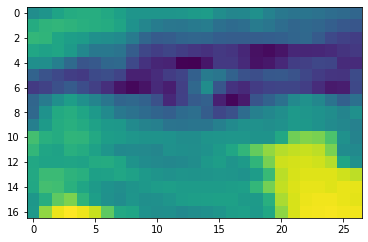

In [6]:
ds_ECEarth_2041 = nc.Dataset('F:/Master_Thesis/Data/EC Earth/2041_UVT/UVT_EcEarth_2041_25km_3h.nc')

#variables
T_ECEarth_2041_25km = np.array(ds_ECEarth_2041['T2M'])
U_ECEarth_2041_25km = np.array(ds_ECEarth_2041['U10M'])
V_ECEarth_2041_25km = np.array(ds_ECEarth_2041['V10M'])

print(T_ECEarth_2041_25km.shape, V_ECEarth_2041_25km.shape, V_ECEarth_2041_25km.shape)
#print(T_ECEarth_2041_25km[0,:,:])
plt.imshow(T_ECEarth_2041_25km[0,:,:])

T_ECEarth_2041_25km = T_ECEarth_2041_25km[:,:,1:26]
U_ECEarth_2041_25km = U_ECEarth_2041_25km[:,:,1:26]
V_ECEarth_2041_25km = V_ECEarth_2041_25km[:,:,1:26]

print(T_ECEarth_2041_25km.shape, V_ECEarth_2041_25km.shape, V_ECEarth_2041_25km.shape)

#### Time

For time data I used a season index using the following short algorithm. Time and elevation data was not used in the final model since to use any metadata in this model one would need to stack the data.  Stacking different variables does require min-max normalisation to have the different variables on the same scale. But this resulted in low performance since the final produced superresolutions are on a different scale.

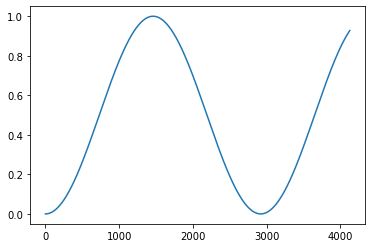

In [7]:
import math as m

time = []

for t in range(4128):
    time.append(m.sin(m.pi*t/2920)**2)
    
plt.plot(time)
plt.show()

In [8]:
time_arr = np.zeros((4128,96,96),dtype='float32')
for t in range(time_arr.shape[0]):
    time_arr[t,:,:] = time[t]

time_arr.shape

(4128, 96, 96)

### Interpolating to same extent

This is done by changing longitude and latitude coordinates of the datasets to a cartesian grid and using nearest neighbor interpolation to get all data on the same grid (WRF 4km).

#### Test future 2041
WRF

In [9]:
# target cartesian coordinates
xt, yt, zt = hf.lon_lat_to_cartesian(lon_WRF_3km_part1.flatten(), lat_WRF_3km_part1.flatten())

EC Earth

In [10]:
#EC Earth 25km

#coordinates
lon_ECEarth_25km_2041 = np.array(ds_ECEarth_2041['lon'])
lat_ECEarth_25km_2041 = np.array(ds_ECEarth_2041['lat'])


if(len(lat_ECEarth_25km_2041.shape)==1):
    lon_ECEarth_25km_2041, lat_ECEarth_25km_2041 = np.meshgrid(lon_ECEarth_25km_2041, lat_ECEarth_25km_2041)
    
lon_ECEarth_25km_2041=lon_ECEarth_25km_2041[:,1:26]    
lat_ECEarth_25km_2041=lat_ECEarth_25km_2041[:,1:26] 

print(lon_ECEarth_25km_2041)
print(lon_ECEarth_25km_2041.shape)
xs, ys, zs = hf.lon_lat_to_cartesian(lon_ECEarth_25km_2041.flatten(), lat_ECEarth_25km_2041.flatten())

tree = hf.cKDTree(np.column_stack((xs, ys, zs)))

[[ 8.325  8.55   8.775  9.     9.225  9.45   9.675  9.9   10.125 10.35
  10.575 10.8   11.025 11.25  11.475 11.7   11.925 12.15  12.375 12.6
  12.825 13.05  13.275 13.5   13.725]
 [ 8.325  8.55   8.775  9.     9.225  9.45   9.675  9.9   10.125 10.35
  10.575 10.8   11.025 11.25  11.475 11.7   11.925 12.15  12.375 12.6
  12.825 13.05  13.275 13.5   13.725]
 [ 8.325  8.55   8.775  9.     9.225  9.45   9.675  9.9   10.125 10.35
  10.575 10.8   11.025 11.25  11.475 11.7   11.925 12.15  12.375 12.6
  12.825 13.05  13.275 13.5   13.725]
 [ 8.325  8.55   8.775  9.     9.225  9.45   9.675  9.9   10.125 10.35
  10.575 10.8   11.025 11.25  11.475 11.7   11.925 12.15  12.375 12.6
  12.825 13.05  13.275 13.5   13.725]
 [ 8.325  8.55   8.775  9.     9.225  9.45   9.675  9.9   10.125 10.35
  10.575 10.8   11.025 11.25  11.475 11.7   11.925 12.15  12.375 12.6
  12.825 13.05  13.275 13.5   13.725]
 [ 8.325  8.55   8.775  9.     9.225  9.45   9.675  9.9   10.125 10.35
  10.575 10.8   11.025 11.25  11.4

In [11]:
lat_ECEarth_25km_2041.shape

(17, 25)

In [12]:
# nearest neighbour
d, inds = tree.query(np.column_stack((xt, yt, zt)), k = 1)

T_ECEarth_near = hf.transform_extent(T_ECEarth_2041_25km, inds, lat_WRF_3km_part1.shape)[0:T_WRF_9km_2021.shape[0]]
U_ECEarth_near = hf.transform_extent(U_ECEarth_2041_25km, inds, lat_WRF_3km_part1.shape)[0:T_WRF_9km_2021.shape[0]]
V_ECEarth_near = hf.transform_extent(V_ECEarth_2041_25km, inds, lat_WRF_3km_part1.shape)[0:T_WRF_9km_2021.shape[0]]

np.shape(T_ECEarth_near)

(2920, 31, 31)

### Downscaling

Current model is doing downscaling by increasing the pixel count, so it wants a low pixel count image and increase the pixel count by an integer factor. For us the low resolution to medium resolution is 16x16 pixels to 32x32. And medium to high resolution is 32x32 to 96x96.

In [13]:
#Future test

T_ECEarth_down = hf.downscale_image(T_ECEarth_near, 6)
U_ECEarth_down = hf.downscale_image(U_ECEarth_near, 6)
V_ECEarth_down = hf.downscale_image(V_ECEarth_near, 6)

In [14]:
T_ECEarth_down.shape, U_ECEarth_down.shape, V_ECEarth_down.shape

((2920, 5, 5, 1), (2920, 5, 5, 1), (2920, 5, 5, 1))

### Writing data to .npy for analysis

In [17]:
# Furture test

#WRF 4 km
np.save('F:/Master_Thesis/Data/Analysis_More_Time/T_WRF_4km.npy', T_WRF_4km_2041)
np.save('F:/Master_Thesis/Data/Analysis_More_Time/U_WRF_4km.npy', U_WRF_4km_2041)
np.save('F:/Master_Thesis/Data/Analysis_More_Time/V_WRF_4km.npy', V_WRF_4km_2041)

#NCEP down
np.save('F:/Master_Thesis/Data/Analysis_More_Time/T_ECEarth_down.npy', T_ECEarth_down)
np.save('F:/Master_Thesis/Data/Analysis_More_Time/U_ECEarth_down.npy', U_ECEarth_down)
np.save('F:/Master_Thesis/Data/Analysis_More_Time/V_ECEarth_down.npy', V_ECEarth_down)

np.save('F:/Master_Thesis/Data/Analysis_More_Time/T_ECEarth_near.npy', T_ECEarth_near)
np.save('F:/Master_Thesis/Data/Analysis_More_Time/U_ECEarth_near.npy', U_ECEarth_near)
np.save('F:/Master_Thesis/Data/Analysis_More_Time/V_ECEarth_near.npy', V_ECEarth_near)

### Writing data to .tfrecord

The current model is implemented with reading data from a .tfrecord which is an Tensorflow data format.

In [23]:
#stacking wind data
Wind_ECEarth_down = np.squeeze(np.stack([U_ECEarth_down, V_ECEarth_down], axis=-1))
    
print(Wind_ECEarth.shape, T_ECEarth_down.shape)

(2920, 5, 5, 2) (2920, 5, 5, 1)


In [24]:
#Furture test

#Temperature
hf.generate_TFRecords(filename = 'F:/Master_Thesis/Data/TFRecords/Future/T_lr_mr_test_future.tfrecord',
                   data_HR = None,
                   data_LR = T_ECEarth_down,
                   mode = 'test')

#wind
hf.generate_TFRecords(filename = 'F:/Master_Thesis/Data/TFRecords/Future/Wind_lr_mr_test_furture.tfrecord',
                   data_HR = None,
                   data_LR = Wind_ECEarth_down,
                   mode = 'test')

In [22]:
Wind_ECEarth_down.shape

(2920, 2)

#### Making MR-HR data set

In [3]:
# getting the generated MR data

# temperature     
T_mr_2041 = np.load('F:/Master_Thesis/Data/SR_data/More_Time/temperature/LR_MR/Future/dataSR.npy')
print(T_mr_2041.shape)

# wind     
Wind_mr_2041 = np.load('F:/Master_Thesis/Data/SR_data/More_Time/wind/LR_MR/Future/dataSR.npy')

Wind_mr_2041.shape

(2920, 10, 10, 1)


(2920, 10, 10, 2)

In [5]:
# Future

# temperature
hf.generate_TFRecords(filename = 'F:/Master_Thesis/Data/TFRecords/Future/T_mr_hr_test_future.tfrecord',
                   data_HR = None,
                   data_LR = T_mr_2041,
                   mode = 'test')

#wind 
hf.generate_TFRecords(filename = 'F:/Master_Thesis/Data/TFRecords/Future/Wind_mr_hr_test_future.tfrecord',
                   data_HR = None,
                   data_LR = Wind_mr_2041,
                   mode = 'test')